### Etape 2 - Préparer les données, former et évaluer les modèles M

In [25]:
#Importing data
import pandas as pd
data = pd.read_pickle("data/trees_clean.p")
data.head(5)


,SOUS_CATEGORIE,CODE_PARENT,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,ANNEEDEPLANTATION,COLLECTIVITE,LONGITUDE,LATITUDE
13,ESP151,ESP36926,1,NaN,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709930,45.201111
14,ESP151,ESP36926,1,NaN,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709895,45.201185
15,ESP151,ESP36926,1,NaN,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709864,45.201254
16,ESP151,ESP36926,1,NaN,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709828,45.201321
17,ESP151,ESP36926,1,Platanus,NaN,NaN,2017.0,Grenoble Alpes Métropole,5.709681,45.201682


In [26]:
#train test splitting and defining Categorical vs numric
from sklearn.model_selection import train_test_split
target = 'ANNEEDEPLANTATION'
num_col = ['LONGITUDE',	'LATITUDE'] #only features, not the target
cat_col = list(set(data.columns).difference([target]).difference(num_col)) 
y = data[target]
X = data[num_col+cat_col]
X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.20, random_state=42)

In [27]:
#preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#numeric pipeline
num_pipe = Pipeline([
    ('SimpleImputer_num', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
#categoric pipeline
cat_pipe = Pipeline([
    # ('SimpleImputer_cat', SimpleImputer(strategy='most_frequent')), #most frequent / const (to be defined)
    ('SimpleImputer_cat', SimpleImputer(strategy='constant',fill_value=None)), #most frequent / const (to be defined)
    ('One Hot Encoder', OneHotEncoder(handle_unknown='infrequent_if_exist'))])
#merging pipeline
pipe = ColumnTransformer([
    ('num',num_pipe,num_col),
    ('cat',cat_pipe,cat_col)])

In [28]:
#transforming using the preprocessing pipe
X_train_pipe = pipe.fit_transform(X_train)
X_test_pipe = pipe.transform(X_test)
#model fitting
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(X_train_pipe,y_train)

LinearRegression()

In [29]:
# Model prediction And Metrics
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import root_mean_squared_error
import numpy as np 
y_pred_train = linReg.predict(X_train_pipe)
y_pred_test = linReg.predict(X_test_pipe)
result = pd.DataFrame()
result.loc['train','MSE'] = mean_squared_error(y_pred_train,y_train)
result.loc['test','MSE'] = mean_squared_error(y_pred_test,y_test)
result.loc['train','RMSE'] = np.sqrt(result.loc['train','MSE'])
result.loc['test','RMSE'] = np.sqrt(result.loc['test','MSE'])
result



,MSE,RMSE
train,32.701118,5.718489
test,39.938895,6.319723


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_norm_hist(data, vline = True, title= True,ax = plt):
    mu, sigma = np.mean(data), np.std(data)
    # count, bins, ignored = plt.hist(data, 30)
    count, bins, ignored = plt.hist(data, 30, density=True)
    ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
            np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
        linewidth=2, color='r')
    
    if vline:
        lline = -.67*sigma + mu
        uline = .67*sigma + mu
        ax.axvline(lline, color='g')
        ax.axvline(uline, color='g')

    if title:
        if ax == plt:
            ax.title("Normal distribution with mean: {:.02f} and StDev: {:.02f}".format(mu, sigma))
        else:
            ax.set_title("Normal distribution with mean: {:.02f} and StDev: {:.02f}".format(mu, sigma))
def standard(data):
    return((data - np.mean(data))/np.std(data))

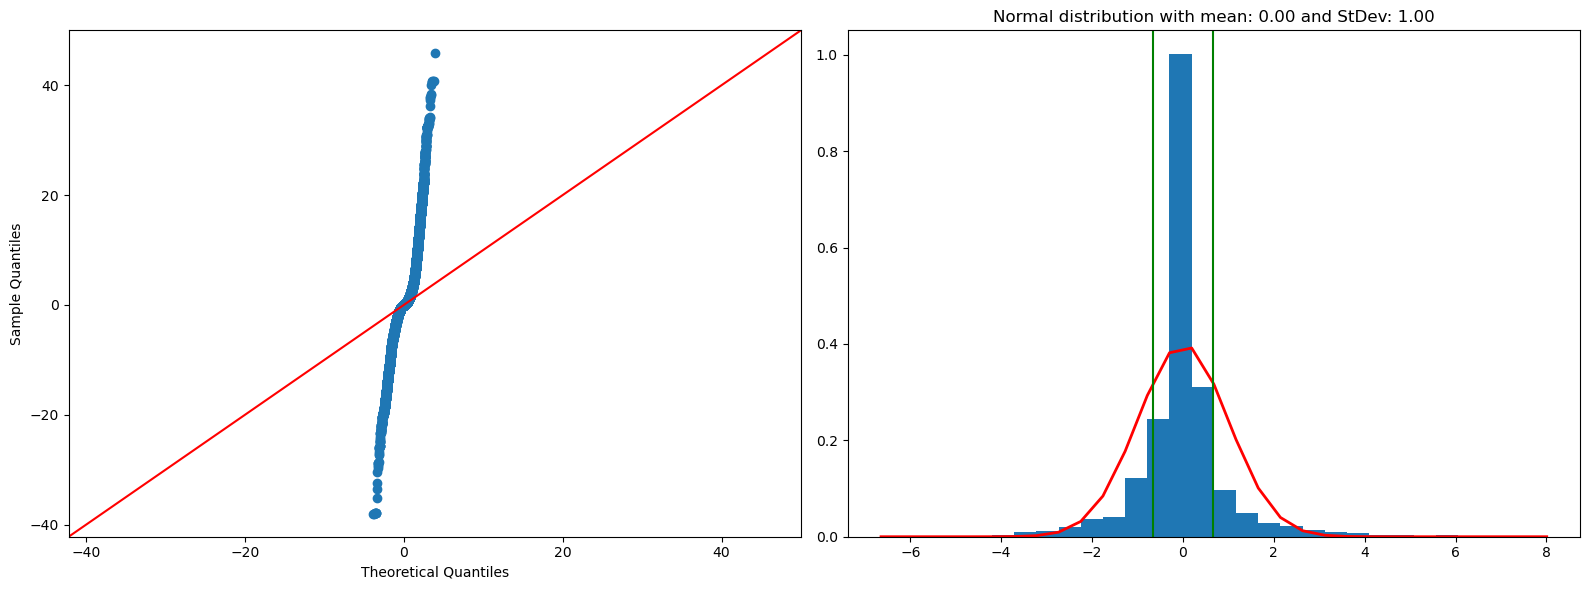

In [31]:
#residuals plot for ml predictions  
import statsmodels.api as sm ## QQplot
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats ## Bell curve
residual_train = y_train - y_pred_train
residual_test = y_train - y_pred_train
np.std(residual_train)
np.mean(residual_train) 

plt.figure(figsize=(16,6))
axes = [plt.subplot(1,2,1),plt.subplot(1,2,2)]
#create Q-Q plot with 45-degree line added to plot
sm.qqplot(residual_train, line='45',ax=axes[0])
plot_norm_hist(standard(residual_test),ax = axes[1])
plt.tight_layout()

In [32]:
from sklearn.model_selection import cross_validate
linReg = LinearRegression()
cross_validate(estimator=linReg,X=X_train_pipe,y=y_train,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')

{'fit_time': array([0.75173283, 0.74732161, 0.68798685, 0.58882713, 0.56221414]),
 'score_time': array([0.00084376, 0.00091505, 0.00115061, 0.00112891, 0.00124049]),
 'test_score': array([-6.36071645, -6.36622013, -6.1206491 , -6.21533239, -6.43405374])}

In [44]:
#input X_train_pipe,y_train, X_test_pipe, y_test
#INITIALIZE MODEL TO USE
def init_model_dict(model_gen):
    model_dict = {
    "model_gen":model_gen,
    "params":None,
    "pickle_file":None,
    "RMSE_CV":None,#[[RMSE_i],mean RMSE, std RMSE]
    "RMSE_test":None}
    return(model_dict)
def base_model(regr_model:dict,model_name:str):
    if model_name in regr_model.keys():
        params = regr_model[model_name]['params']
        if params==None:
            return(regr_model[model_name]['model_gen']())
        else:
            return(regr_model[model_name]['model_gen'](params))
import os.path
import time #exec time display
import joblib
#FIT AND STORE
def fitAndStoreModels(regr_model:dict,X_train,y_train, reset=False):
    for model_name in regr_model.keys():
        if regr_model[model_name]['pickle_file'] == None:
            file_name = f"{model_name}.pkl"
            if (not os.path.isfile(file_name)) or reset:
                print(f"Creating and fitting model {model_name}")
                start_time = time.time()
                model = base_model(regr_model,model_name)
                model.fit(X_train,y_train)
                print(f"done in {time.time() - start_time} s")
                joblib.dump(model, file_name)
                print(f"Storing model {model_name} in {file_name}\nto use it :\nmodel = joblib.load({file_name})")
            else:
                print(f"The model {model_name} has been already fit :\n set reset=True to refit the model")
            regr_model[model_name]['pickle_file'] = file_name
    return None
#FIT AND STORE
def storeModel(regr_model:dict,model,model_name, params = None):
    regr_model[model_name] = init_model_dict(None)
    file_name = f"{model_name}.pkl"
    joblib.dump(model, file_name)
    regr_model[model_name]['pickle_file'] = file_name
    regr_model[model_name]['params'] = params
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_validate
def compute_CV(regr_model:dict,X_train,y_train, n_fold:int, reset = False):
    for model_name in regr_model.keys():
        if regr_model[model_name]['RMSE_CV'] == None or reset:
            print(f"Computing Cross_validation on model {model_name} with {n_fold} folds")
            model = base_model(regr_model,model_name)
            regr_model[model_name]['RMSE_CV'] = cross_validate(estimator=model,X=X_train,y=y_train,cv=n_fold,n_jobs=-1,scoring='neg_root_mean_squared_error')
            print(f"CV Done:{regr_model[model_name]['RMSE_CV']}")
    return None
#RMSE
def compute_RMSE(regr_model:dict,X_test,y_test,reset = False):
    for model_name in regr_model.keys():
        if regr_model[model_name]['pickle_file'] != None and (regr_model[model_name]['RMSE_test'] == None or reset):
            print(f"Loading and predictions on model {model_name}")
            start_time = time.time()
            model = joblib.load(regr_model[model_name]['pickle_file'])
            y_pred_test = model.predict(X_test)
            print(f"done in {time.time() - start_time} s")
            regr_model[model_name]['RMSE_test'] = root_mean_squared_error(y_pred_test,y_test)
            print(f"RMSE {model_name} (test): {regr_model[model_name]['RMSE_test']}")
    return None
import pandas as pd 
#DISPLAY
def display_result(regr_model:dict):
    df = pd.DataFrame(columns=list(regr_model.keys()))
    for model_name in regr_model.keys():
        df.loc['RMSE_test',model_name] = regr_model[model_name]['RMSE_test']
        df.loc['CV mean NRMSE',model_name] = np.mean(regr_model[model_name]['RMSE_CV']['test_score'])
        df.loc['CV std NRMSE',model_name] = np.std(regr_model[model_name]['RMSE_CV']['test_score'])
    display(df)
    return None
            

In [34]:
regr_model

{'LinRegr': {'model_gen': sklearn.linear_model._base.LinearRegression,
  'params': None,
  'pickle_file': 'LinRegr.pkl',
  'RMSE_CV': {'fit_time': array([0.64505601, 0.5326252 , 0.72595739, 0.55489755, 0.52501082]),
   'score_time': array([0.00116849, 0.00124121, 0.00155592, 0.00112605, 0.00087357]),
   'test_score': array([-6.36071645, -6.36622013, -6.1206491 , -6.21533239, -6.43405374])},
  'RMSE_test': 6.319722696237938},
 'GBR': {'model_gen': sklearn.ensemble._gb.GradientBoostingRegressor,
  'params': None,
  'pickle_file': 'GBR.pkl',
  'RMSE_CV': {'fit_time': array([3.36351418, 3.0622921 , 3.62114501, 3.28059316, 3.76264262]),
   'score_time': array([0.00909328, 0.01034331, 0.00898004, 0.00825763, 0.00797391]),
   'test_score': array([-9.51664652, -9.40875749, -9.5389165 , -9.29750801, -9.79800319])},
  'RMSE_test': 9.472773655659404},
 'SVR': {'model_gen': sklearn.svm._classes.SVR,
  'params': None,
  'pickle_file': 'SVR.pkl',
  'RMSE_CV': {'fit_time': array([30.93022704, 25.6111

In [35]:
### RESETS THE MODELS
#Testing and compairing different ml-models for regression
from sklearn.svm import SVR #Support Vector Machine
from sklearn.ensemble import GradientBoostingRegressor #Gradient Boosting Regression
from sklearn.linear_model import LinearRegression #Linear Regression
regr_model = {}
inputs = [('LinRegr',LinearRegression),('GBR',GradientBoostingRegressor)]
# inputs = [('LinRegr',LinearRegression),('SVR',SVR),('GBR',GradientBoostingRegressor)]
for (name,model_gen) in inputs:
    regr_model[name]=init_model_dict(model_gen)
    print(f"Initialize model {name}")

Initialize model LinRegr
Initialize model GBR


In [36]:
from sklearn.svm import SVR #Support Vector Machine
def SVR_2():
    return SVR(gamma='auto')

In [76]:
# regr_model['SVR2']=init_model_dict(SVR_2)
fitAndStoreModels(regr_model,X_train_pipe,y_train,reset=False)
compute_CV(regr_model,X_train=X_train_pipe,y_train=y_train,n_fold=5)
compute_RMSE(regr_model,X_test_pipe, y_test)
display_result(regr_model)

,LinRegr,GBR,SVR2,RFC_GSCV
RMSE_test,6.319723,9.472774,13.496029,4.49603
CV mean NRMSE,-6.299394,-9.512994,-13.941086,-4.654768
CV std NRMSE,0.114346,0.167672,0.118328,0.203396


In [39]:
#Hyper-parameter Tuning with GridSearchCV in Sklearn
# GRID SEARCH CV for selecting parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None]
}
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=2,
                           scoring='neg_root_mean_squared_error')
# Fit GridSearchCV to the training data
grid_search.fit(X_train_pipe, y_train)
# Get the best model from GridSearchCV and make predictions
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  10.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  11.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  11.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.8s
[CV] END max_depth=None, max_

/home/thomas.mari@Digital-Grenoble.local/anaconda3/envs/ml1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  11.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  11.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, ma

In [45]:
storeModel(regr_model, best_rf_model, 'RFC_GSCV',grid_search.best_params_)

In [52]:
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by=['mean_test_score'],ascending = False).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,23.918838,0.784938,0.418981,0.048232,None,sqrt,1,5,150,"{'max_depth': None, 'max_features': 'sqrt', 'm...",-4.785093,-4.552142,-4.682037,-4.329729,-4.924841,-4.654768,0.203396,1
55,67.060710,0.583696,0.168706,0.010701,None,None,1,2,100,"{'max_depth': None, 'max_features': None, 'min...",-4.588550,-4.539084,-4.780808,-4.656003,-4.826768,-4.678243,0.109985,2


In [77]:
#RSME test 
y_pred = best_rf_model.predict(X_test_pipe)
root_mean_squared_error(y_pred,y_test)
regr_model['RFC_GSCV']['RMSE_CV'] = {'test_score':[-4.785093,	-4.552142,	-4.682037,	-4.329729,	-4.924841]}
display_result(regr_model)

,LinRegr,GBR,SVR2,RFC_GSCV
RMSE_test,6.319723,9.472774,13.496029,4.49603
CV mean NRMSE,-6.299394,-9.512994,-13.941086,-4.654768
CV std NRMSE,0.114346,0.167672,0.118328,0.203396


In [80]:
y_pred_train = best_rf_model.predict(X_train_pipe)
root_mean_squared_error(y_pred_train,y_train)


1.7070209297326893

In [54]:
joblib.dump(grid_results,"df_grid_search_RFC_results.pkl")

['df_grid_search_RFC_results.pkl']

In [ ]:
regr_model['LinRegr']['RMSE_CV']
np.mean(regr_model[model_name]['RMSE_CV']['test_score'])

{'test_score': [-4.785093, -4.552142, -4.682037, -4.329729, -4.924841]}